# IMPORT MODULES

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.pipeline import Pipeline

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

bc = pd.read_csv('seatle_after_feature_engineering.csv')

# SiteEnergyUse

/Users/tico/Library/Python/3.9/lib/python/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


                         feature  importance
0           GFAByBuildingsScaler    0.479839
2                YearBuiltScaler    0.116634
1       PropertyGFAParkingScaler    0.083973
31   p_Supermarket/Grocery Store    0.061918
15  p_Non-Refrigerated Warehouse    0.040311
27                p_Retail Store    0.028294
23                        p_Rare    0.021031
3                         HasGas    0.019782
17                       p_Other    0.016915
21                     p_Parking    0.016088
Results for DummyRegressor:
R² Score: -0.0020
MAE: 1701739.4651
MAPE: 129.24%
RMSE: 2230894.6926
------------------------------
Results for LinearRegression:
R² Score: 0.4578
MAE: 1181316.0325
MAPE: 71.62%
RMSE: 1640954.4027
------------------------------


/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


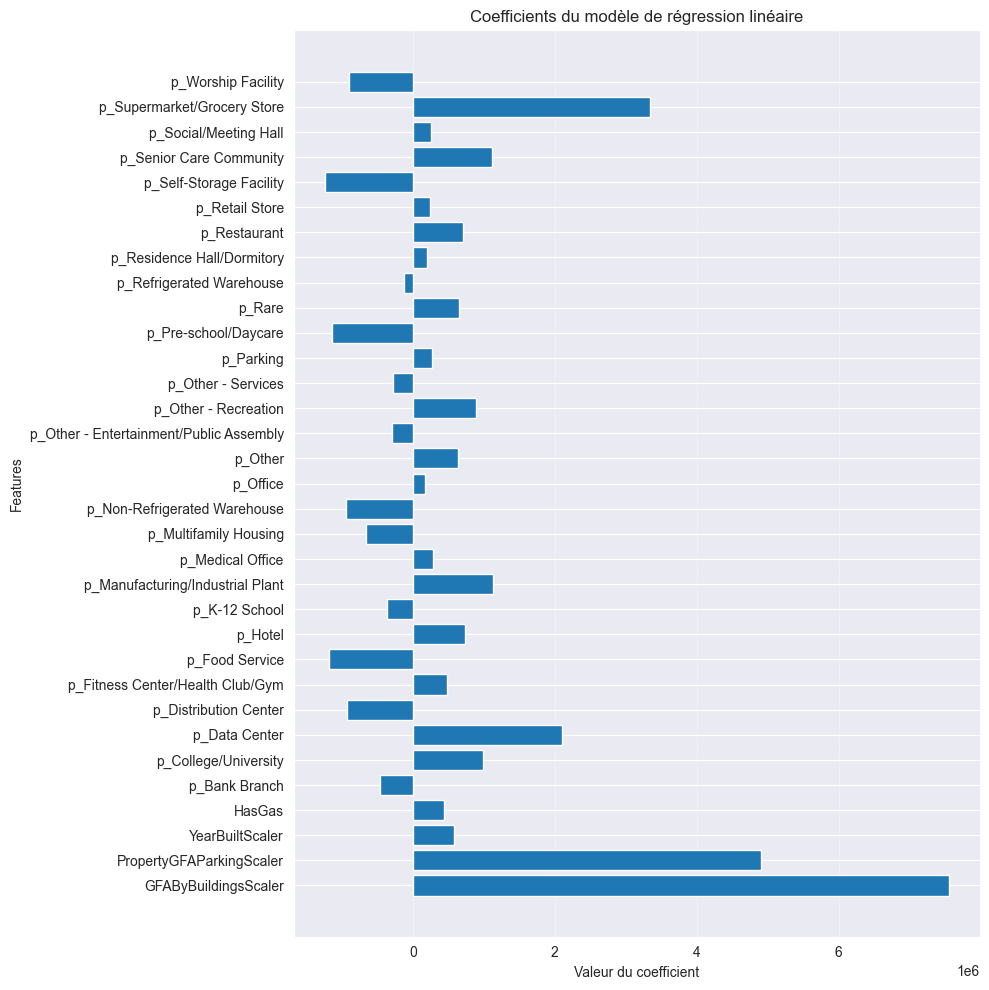

Results for SVR:
R² Score: -0.1419
MAE: 1609741.7084
MAPE: 90.01%
RMSE: 2381447.4093
------------------------------
Results for RandomForestClassifier:
R² Score: 0.2012
MAE: 1367312.6486
MAPE: 73.67%
RMSE: 1991846.5175
------------------------------


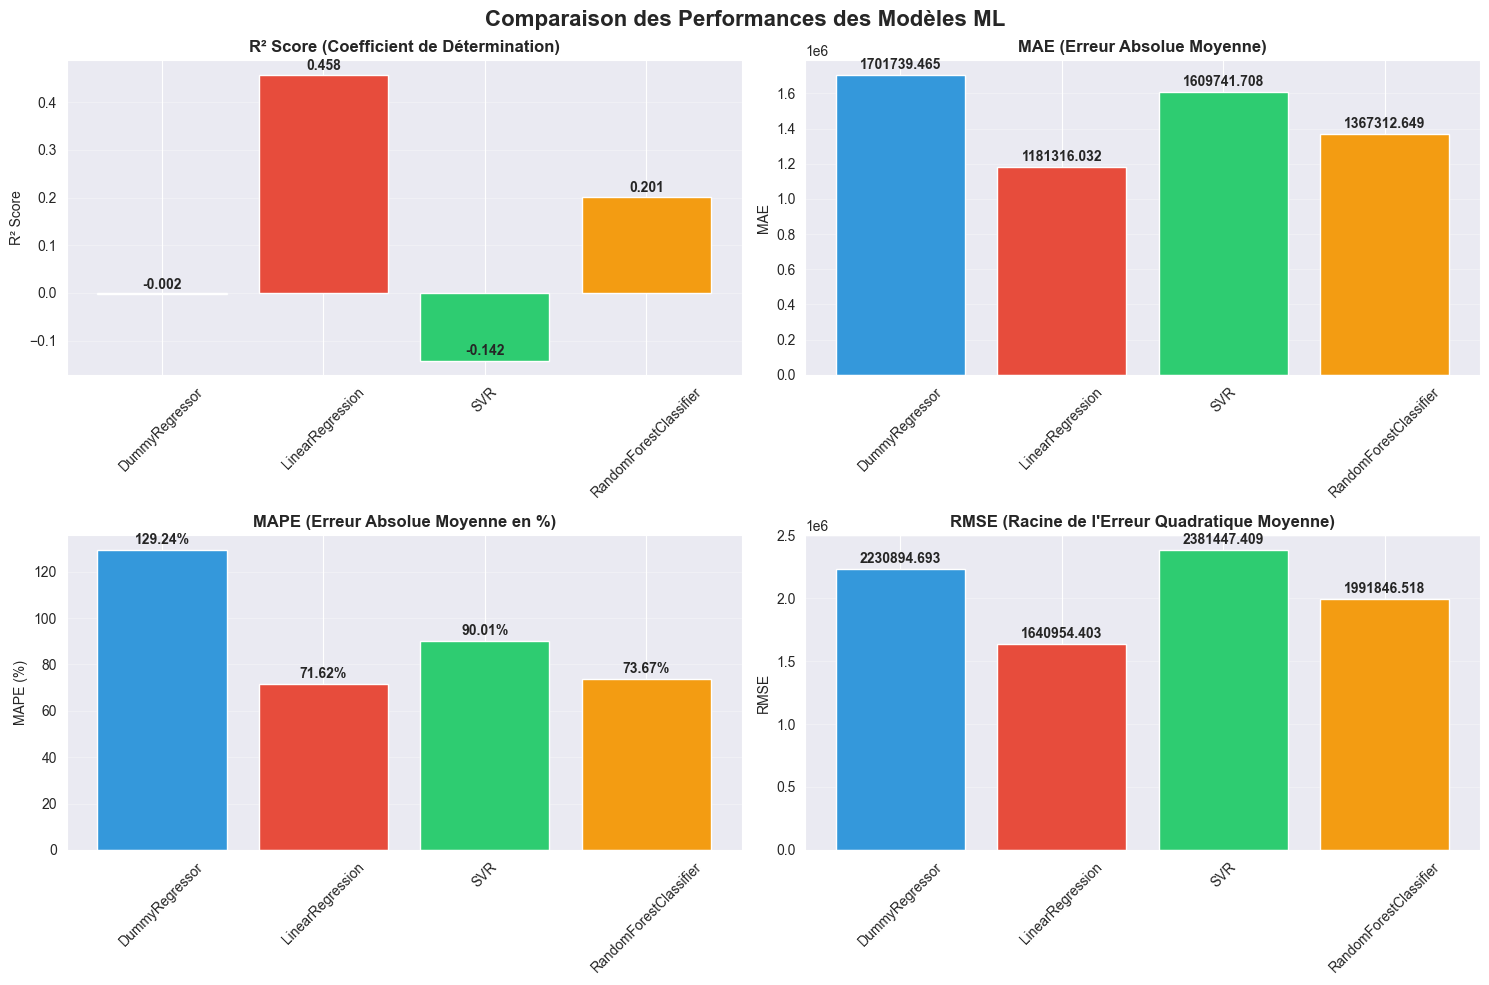

In [61]:
# Calcul de la surface par batiment
a = bc['PropertyGFABuilding(s)']
b = bc['NumberofBuildings']
bc['GFAByBuildings'] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# Calcul de la surface par etages
a = bc['PropertyGFABuilding(s)']
b = bc['NumberofFloors']
bc['GFAByFloors'] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

scaler = MinMaxScaler()
bc['PropertyGFAParkingScaler'] = scaler.fit_transform(bc[['PropertyGFAParking']])

scaler = MinMaxScaler()
bc['GFAByBuildingsScaler'] = scaler.fit_transform(bc[['GFAByBuildings']])

scaler = MinMaxScaler()
bc['YearBuiltScaler'] = scaler.fit_transform(bc[['YearBuilt']])

base_columns = ['GFAByBuildingsScaler', 'PropertyGFAParkingScaler','YearBuiltScaler', 'HasGas']
p_columns = [col for col in bc.columns if col.startswith('p_')]
ppt_columns = [col for col in bc.columns if col.startswith('ppt_')]
nbh_columns = [col for col in bc.columns if col.startswith('nbh_')]
all_columns = base_columns + p_columns # + nbh_columns  + ppt_columns

X = bc[all_columns]
y = bc['SiteEnergyUse(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)

#######################################
#######################################



#######################################
#######################################

model = RandomForestRegressor(n_estimators=100, random_state=666)
model.fit(X_train, y_train)

importances = model.feature_importances_

# Associer noms de colonnes + importance
feat_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importances[:10])

#######################################
#######################################

list_model = []

def modelisation(model_name,model,X_train,y_train,X_test,y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    model_results = {
            'model_name': model_name,
            'r2_score': r2,
            'mae': mae,
            'mape': mape,
            'rmse': rmse
        }

    list_model.append(model_results)

    print(f"Results for {model_name}:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

    return list_model

#######################################
#######################################

model_name = 'DummyRegressor'
model = DummyRegressor(strategy="mean")  # ou "median"

modelisation(model_name,model,X_train,y_train,X_test,y_test)

#######################################
#######################################

model_name = 'LinearRegression'
model = LinearRegression()

modelisation(model_name,model,X_train,y_train,X_test,y_test)

plt.figure(figsize=(10, 10))
plt.barh(list(X.columns), model.coef_)
plt.title('Coefficients du modèle de régression linéaire')
plt.xlabel('Valeur du coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#######################################
#######################################

model_name = 'SVR'
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1, gamma="scale"))
])

modelisation(model_name,model,X_train,y_train,X_test,y_test)

#######################################
#######################################

model_name = 'RandomForestClassifier'
model = RandomForestClassifier(
    n_estimators=100,   # nombre d’arbres
    max_depth=None,     # profondeur max (None = jusqu’à pureté)
    random_state=666
)

modelisation(model_name,model,X_train,y_train,X_test,y_test)

#######################################
#######################################

# Convertir en DataFrame pour faciliter la manipulation
df = pd.DataFrame(list_model)

# Configuration de la figure avec sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparaison des Performances des Modèles ML', fontsize=16, fontweight='bold')

# Couleurs pour les barres
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

# 1. R² Score (plus c'est élevé, mieux c'est)
axes[0,0].bar(df['model_name'], df['r2_score'], color=colors[:len(df)])
axes[0,0].set_title('R² Score (Coefficient de Détermination)', fontweight='bold')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)
# Ajouter les valeurs sur les barres
for i, v in enumerate(df['r2_score']):
    axes[0,0].text(i, v + max(df['r2_score'])*0.01, f'{v:.3f}',
                  ha='center', va='bottom', fontweight='bold')

# 2. MAE (plus c'est bas, mieux c'est)
axes[0,1].bar(df['model_name'], df['mae'], color=colors[:len(df)])
axes[0,1].set_title('MAE (Erreur Absolue Moyenne)', fontweight='bold')
axes[0,1].set_ylabel('MAE')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(df['mae']):
    axes[0,1].text(i, v + max(df['mae'])*0.01, f'{v:.3f}',
                  ha='center', va='bottom', fontweight='bold')

# 3. MAPE (plus c'est bas, mieux c'est)
axes[1,0].bar(df['model_name'], df['mape'], color=colors[:len(df)])
axes[1,0].set_title('MAPE (Erreur Absolue Moyenne en %)', fontweight='bold')
axes[1,0].set_ylabel('MAPE (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(df['mape']):
    axes[1,0].text(i, v + max(df['mape'])*0.01, f'{v:.2f}%',
                  ha='center', va='bottom', fontweight='bold')

# 4. RMSE (plus c'est bas, mieux c'est)
axes[1,1].bar(df['model_name'], df['rmse'], color=colors[:len(df)])
axes[1,1].set_title('RMSE (Racine de l\'Erreur Quadratique Moyenne)', fontweight='bold')
axes[1,1].set_ylabel('RMSE')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(df['rmse']):
    axes[1,1].text(i, v + max(df['rmse'])*0.01, f'{v:.3f}',
                  ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#######################################
#######################################



# Cross_val_score

In [62]:
from sklearn.model_selection import KFold


def perform_cross_validation(
    X: pd.DataFrame,
    y: pd.Series,
    model,
    cross_val_type, # La variante de validation croisée que nous souhaitons utiliser
    scoring_metrics: tuple, # Metriques de notre choix
    return_estimator=False, # Si nous souhaitons stocker les modèles de chaque fold
    groups=None, # Nous verrons l’utilité de cet argument juste après
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(
            "Average Train {metric} : {metric_value}".format(
                metric=metric,
                metric_value=np.mean(scores["train_" + metric]),
            )
        )
        print(
            "Train {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["train_" + metric])
            )
        )

        print(
            "Average Test {metric} : {metric_value}".format(
                metric=metric, metric_value=np.mean(scores["test_" + metric])
            )
        )
        print(
            "Test {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["test_" + metric])
            )
        )

    return scores


linear_model = LinearRegression()
classification_scoring_metrics = ("neg_mean_squared_error", "r2", "neg_mean_absolute_error")

scores_LinearRegression = perform_cross_validation(
    X=X,
    y=y,
    model=linear_model,
    cross_val_type=KFold(n_splits=5, shuffle=True, random_state=666), #Par défaut, le nombre de folds est 5
    scoring_metrics=classification_scoring_metrics,
)




Average Train neg_mean_squared_error : -2178109150678.6406
Train neg_mean_squared_error Standard Deviation : 74296046032.66539
Average Test neg_mean_squared_error : -2358533481998.354
Test neg_mean_squared_error Standard Deviation : 284390423136.32916
Average Train r2 : 0.5514886045613084
Train r2 Standard Deviation : 0.010361444259787985
Average Test r2 : 0.5136550178699167
Test r2 Standard Deviation : 0.03871398503810837
Average Train neg_mean_absolute_error : -1073991.895645347
Train neg_mean_absolute_error Standard Deviation : 20083.949375698914
Average Test neg_mean_absolute_error : -1114589.9117267649
Test neg_mean_absolute_error Standard Deviation : 62518.972897736305


/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: i

# RandomForestRegressor